In [21]:
import numpy as np
import matplotlib.pyplot as plt
from xfoil import XFoil
from xfoil.model import Airfoil
from scipy.interpolate import CubicSpline
from scipy.special import comb
import math
import os
from deap import base, creator, tools, algorithms
from xfoil.test import naca0012
import shutil
try:
    shutil.rmtree("populations")
    os.mkdir("populations")
except:
    os.mkdir("populations")
# Define the airfoil function
n_ctr_pts = 10
angle_attack = 10
n_times = 120
max_iterations= 100
# Genetic Algorithm parameters
population_size = 100
max_generations = 200
mach = 0.15
re = 1e6
std_x = [naca0012.x[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [1]
std_y = [naca0012.y[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [0]


In [22]:
def normalize_airfoil(points):
    # Extract x-coordinates and y-coordinates
    x_coords = np.array([p[0] for p in points])
    y_coords = np.array([p[1] for p in points])
    
    # Find the leading edge (min x-coordinate) and trailing edge (max x-coordinate)
    x_min = np.min(x_coords)
    x_max = np.max(x_coords)
    
    # Calculate the chord length
    chord_length = x_max - x_min
    
    # Normalize x-coordinates to make the chord length equal to 1
    normalized_x_coords = (x_coords - x_min) / chord_length
    
    # Combine normalized x-coordinates and original y-coordinates
    normalized_points = np.array(list(zip(normalized_x_coords, y_coords)))
    
    return normalized_points
def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

def airfoil(h, n_ctr_pts=n_ctr_pts, chord=naca0012.x, nTimes=n_times):
    top_half = [(x, y) for x, y in zip(chord[:n_ctr_pts], h[0])] 
    low_half = [(x, -y) for x, y in zip(chord[n_ctr_pts:], h[1])]
    pts =  top_half +  low_half  # Include leading and trailing edges
    pts = np.array(pts)
    x = np.append(pts[:, 0][:-1], pts[:, 0][0])
    y = np.append(pts[:, 1][:-1], pts[:, 1][0])
    t = np.linspace(0.0, 1, nTimes)
    polynomial_array = np.array([ bernstein_poly(i, n_ctr_pts*2-1, t) for i in range(0, n_ctr_pts*2)   ])
    xvals = np.dot(x, polynomial_array)
    yvals = np.dot(y, polynomial_array)
    pts = np.column_stack([xvals, yvals])
    pts = normalize_airfoil(pts)
    #plot_foil(pts)
    """plt.figure(figsize=(10, 5))
    plt.scatter(x[0], y[0],  color='r', marker='o')
    plt.scatter(x[-1], y[-1])
    plt.plot(x,y)
    plt.plot(xvals, yvals)
    plt.grid(True)"""
    return pts, Airfoil(x=pts[:, 0], y=pts[:, 1])

def plot_foil(pts, std_points=[naca0012.x, naca0012.y]):
    # Extract x and y coordinates for plotting
    x, y = pts[:, 0], pts[:, 1]
    # Plot the airfoil shape
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label='Airfoil Shape', color='b', marker='o')
    plt.fill(x, y, 'b', alpha=0.3)  # Fill the shape for better visualization
    plt.plot(std_points[0], std_points[1], label='NACA0012', color='r', marker='o')
    plt.fill(std_points[0], std_points[1], 'r', alpha=0.3)
    # Adding labels and legend
    plt.xlabel('Chord Position')
    plt.ylabel('Height')
    plt.title('Airfoil Shape')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


In [23]:
def fitness(air):
    xf = XFoil()
    xf.airfoil = air
    xf.Re = re
    xf.mach = mach
    xf.max_iter = 100
    cl, cd, cm, cp = xf.a(angle_attack)
    return cl, cd

In [24]:
# Function to evaluate fitness (maximize Cl, minimize Cd)
def evaluate_airfoil(individual):
    # Decode individual (genotype) into airfoil parameters
    h = np.array([individual[:n_ctr_pts], np.abs(individual[n_ctr_pts:])])
    
    # Generate airfoil shape
    pts, foil = airfoil(h, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
    
    # Use XFoil to evaluate Cl and Cd
    xf = XFoil()
    xf.airfoil = foil
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis

    cl, cd, cm, cp = xf.a(angle_attack)
    if math.isnan(cl) or math.isnan(cd):
        return 0, -10e5
    else:
        # Return Cl and -Cd (minimize Cd -> maximize -Cd)
        return cl, -cd


In [25]:
# Function to evaluate fitness (maximize Cl, minimize Cd)
def evaluate_airfoil_angle_attacks(individual, min=-20, max=20, step=1):
    # Decode individual (genotype) into airfoil parameters
    h = np.array([individual[:n_ctr_pts], np.abs(individual[n_ctr_pts:])])
    
    # Generate airfoil shape
    pts, foil = airfoil(h, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
    
    # Use XFoil to evaluate Cl and Cd
    xf = XFoil()
    xf.airfoil = foil
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis
    a, cl, cd, cm, cp = xf.aseq(min, max, step)

    # Return Cl and -Cd (minimize Cd -> maximize -Cd)
    return a, cl, cd


In [26]:
def naca_eval(min=-20, max=20, step=1):
    xf = XFoil()
    xf.airfoil = naca0012
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis
    a, cl, cd, cm, cp = xf.aseq(min, max, step)
    return a, cl, cd

In [27]:

# Create DEAP types: FitnessMin for minimization, with 2 objectives (Cl and -Cd)
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Initialize DEAP toolbox
toolbox = base.Toolbox()

# Register individuals and population generator
toolbox.register("attr_float", np.random.uniform, 0, 0.2)  # Genes initialization
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_ctr_pts*2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)  # Gaussian mutation
toolbox.register("select", tools.selNSGA2)  # NSGA-II selection

toolbox.register("evaluate", evaluate_airfoil)

# Create initial population (using NACA0012 as baseline)
initial_population = []
for _ in range(population_size):
    perturbation = np.random.normal(0, 0.01, size=n_ctr_pts * 2)
    individual = np.concatenate((std_y[:n_ctr_pts], np.abs(std_y[n_ctr_pts:]))) + perturbation
    initial_population.append(individual)

# Save population function
def save_population(population, generation):
    valid_individuals = [ind for ind in population if ind.fitness.values != (0.0, -1e5)]
    with open(f'populations/population_gen_{generation}.txt', 'w') as file:
        for ind in valid_individuals:
            file.write(f"{ind} Fitness: {ind.fitness.values}\n")

# Modified eaMuPlusLambda with a callback for saving populations
def custom_eaMuPlusLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen, stats=None,
                          halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the entire population
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalid_ind))
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = list(map(toolbox.clone, offspring))
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if np.random.random() < cxpb:
                toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        for mutant in offspring:
            if np.random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace the population with the offspring
        population[:] = offspring

        if halloffame is not None:
            halloffame.update(population)

        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        # Save the population of the current generation
        save_population(population, gen)

    return population, logbook

# Create the initial population
pop = toolbox.population(n=population_size)

# Apply the modified DEAP algorithm
custom_eaMuPlusLambda(pop, toolbox, mu=population_size, lambda_=population_size, cxpb=0.5, mutpb=0.2, ngen=max_generations, verbose=True)



gen	nevals
0  	100   
1  	51    
2  	65    
3  	56    
4  	57    
5  	66    
6  	65    
7  	57    
8  	63    
9  	61    
10 	60    
11 	57    
12 	57    
13 	62    
14 	62    
15 	62    
16 	42    
17 	67    
18 	56    
19 	60    
20 	67    
21 	62    
22 	61    
23 	58    
24 	51    
25 	63    
26 	57    
27 	52    
28 	47    
29 	53    
30 	60    
31 	73    
32 	69    
33 	59    
34 	56    
35 	65    
36 	73    
37 	60    
38 	57    
39 	58    
40 	59    
41 	61    
42 	46    
43 	50    
44 	64    
45 	57    
46 	46    
47 	56    
48 	65    
49 	64    
50 	66    
51 	54    
52 	62    
53 	71    
54 	64    
55 	57    
56 	49    
57 	68    
58 	61    
59 	57    
60 	67    
61 	59    
62 	48    
63 	61    
64 	68    
65 	62    
66 	71    
67 	67    
68 	67    
69 	68    
70 	50    
71 	66    
72 	68    
73 	56    
74 	51    
75 	65    
76 	56    
77 	56    
78 	61    
79 	56    
80 	64    
81 	76    
82 	50    
83 	61    
84 	59    
85 	54    
86 	60    
87 	52    
88 	67    
89 	52    

([[-0.13487799703471476,
   -2.6568480356549515,
   0.6240644950113611,
   -126.82732116721994,
   50.938756816809246,
   -0.07077594412473573,
   -0.22891227078825283,
   -21.24140701852567,
   -0.5456428438883474,
   3.7653846806933995,
   0.26539472640953077,
   -0.2868587945117166,
   -1.7755846495249124,
   -0.004807358273673103,
   0.15580124893970942,
   -54.56237731867534,
   -0.048475698442283874,
   -0.4302589777637188,
   7.964108778200594,
   -17.110214558120347],
  [-0.685388555616292,
   -1.9036088099567863,
   -2.0648725572843647,
   31.41882827107427,
   -3.8790284756157245,
   -1.0340967758138813,
   -0.33777516186446455,
   3.547376247083143,
   0.8247369721507375,
   0.7180169314699555,
   0.7487616029543502,
   -0.11920372796682581,
   4.083714045886951,
   -0.03016192786939907,
   0.80583594213341,
   -128.90928354075453,
   0.1076832696005677,
   -4.207091085707404,
   -2.2317884182307033,
   1.6857564768181046],
  [1.8310471111665554,
   13.956857522259659,
   -0

<function matplotlib.pyplot.show(close=None, block=None)>

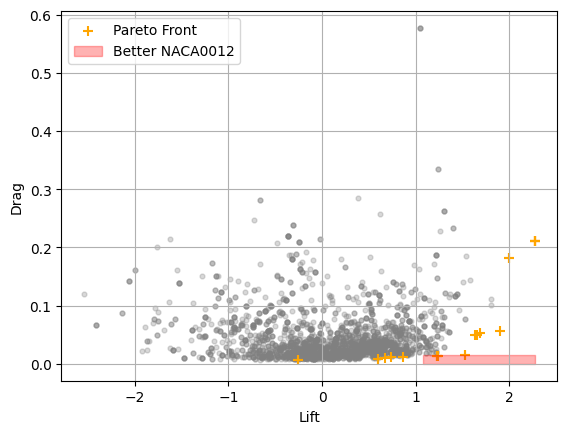

In [41]:
import os
import matplotlib.pyplot as plt

def load_population(folder="populations"):
    populations = {}
    
    for filename in os.listdir(folder):
        if filename.startswith("population_gen_") and filename.endswith(".txt"):
            gen_num = int(filename.split('_')[-1].split('.')[0])
            population = []
            
            with open(os.path.join(folder, filename), 'r') as file:
                for line in file:
                    if line.strip():
                        parts = line.strip().split('Fitness:')
                        individual_str = parts[0].strip()[1:-1]
                        fitness_str = parts[1].strip()[1:-1]
                        individual = list(map(float, individual_str.split(',')))
                        fitness = tuple(map(float, fitness_str.split(',')))
                        population.append((individual, fitness))
            
            populations[gen_num] = population
    
    return populations

def dominates(point1, point2):
    return (point1[0] >= point2[0] and point1[1] <= point2[1]) and (point1 != point2)

def pareto_front(points):
    pareto_points = []
    for i, point1 in enumerate(points):
        is_dominated = False
        for j, point2 in enumerate(points):
            if i != j and dominates(point2, point1):
                is_dominated = True
                break
        if not is_dominated:
            pareto_points.append(point1)
    return pareto_points

# Load populations from the folder
populations = load_population()

lifts = []
drags = []
for gen, population in populations.items():
    for ind, fit in population:
        if fit[0] != 0 and fit[1] != -1e5:
            lifts.append(fit[0])
            drags.append(-fit[1])

# Combine the lists into a list of points
points = list(zip(lifts, drags))

# Find the Pareto front
pareto = pareto_front(points)

# Separate the Pareto front points
pareto_l = [p[0] for p in pareto]
pareto_d = [p[1] for p in pareto]

# Remove Pareto front points from lifts and drags
remaining_points = [p for p in points if p not in pareto]
remaining_l = [p[0] for p in remaining_points]
remaining_d = [p[1] for p in remaining_points]
# Get fitness for NACA0012
naca0012_fit = np.array(fitness(naca0012))

# Plotting
plt.figure()
plt.scatter(remaining_l, remaining_d, color="grey", s=12, alpha=0.3)
plt.scatter(pareto_l, pareto_d, color="orange", marker='+', s=50, label="Pareto Front")

# Define the shaded area
plt.fill_betweenx(
    y=[0, naca0012_fit[1]], 
    x1=naca0012_fit[0], 
    x2=max(lifts), 
    color='red', 
    alpha=0.3, 
    label="Better NACA0012"
)

plt.xlabel("Lift")
plt.ylabel("Drag")
plt.legend()
plt.grid(True)
plt.show


## Pareto front results

#### Section 1
ploting the Airfoils that give a better drag and lift compared to the NACA0012
#### Section 2
plotting all the pareto front individuals

## Section 1

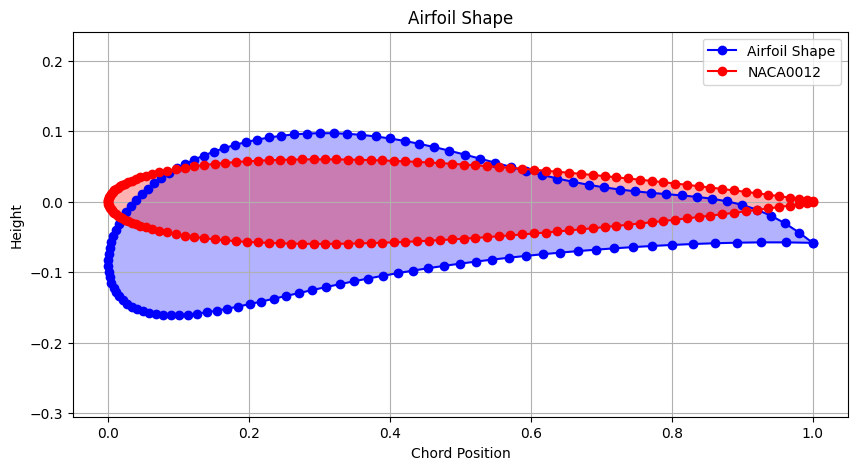

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.236806869506836, drag : 0.013636712916195393
direction 1.00, lift improvement 14.42%, drag improvement 8.95%


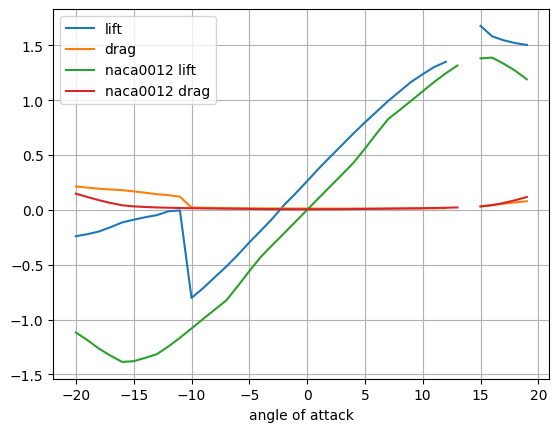

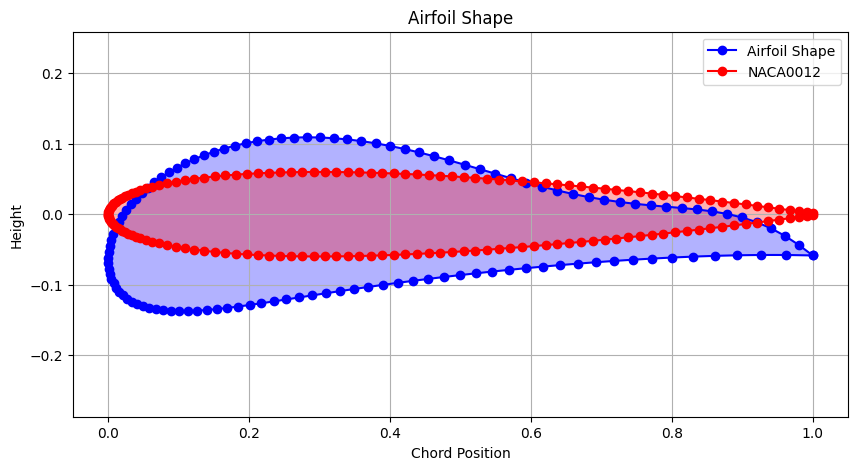

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.5274044275283813, drag : 0.014758596196770668
direction 1.00, lift improvement 41.30%, drag improvement 1.46%


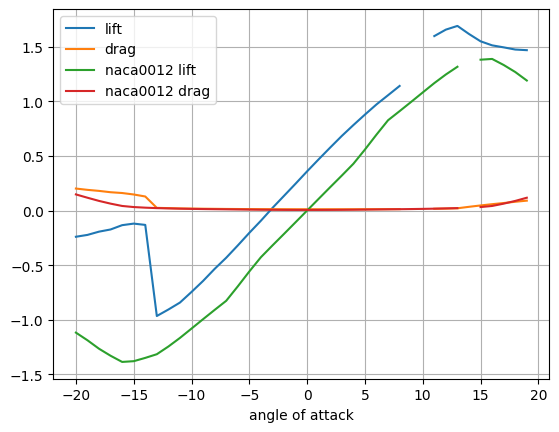

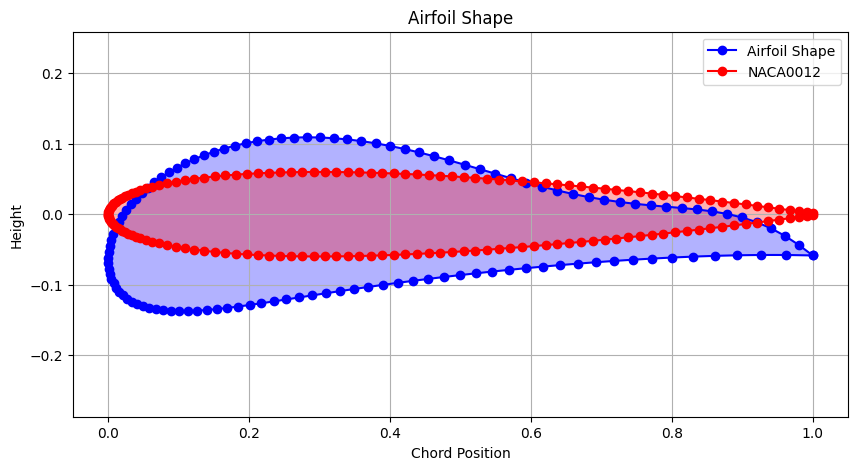

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.5274044275283813, drag : 0.014758596196770668
direction 1.00, lift improvement 41.30%, drag improvement 1.46%


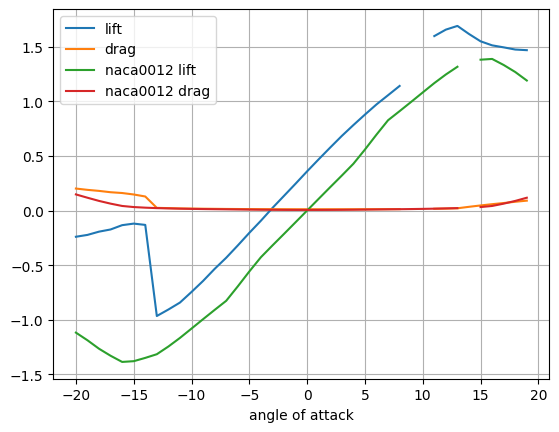

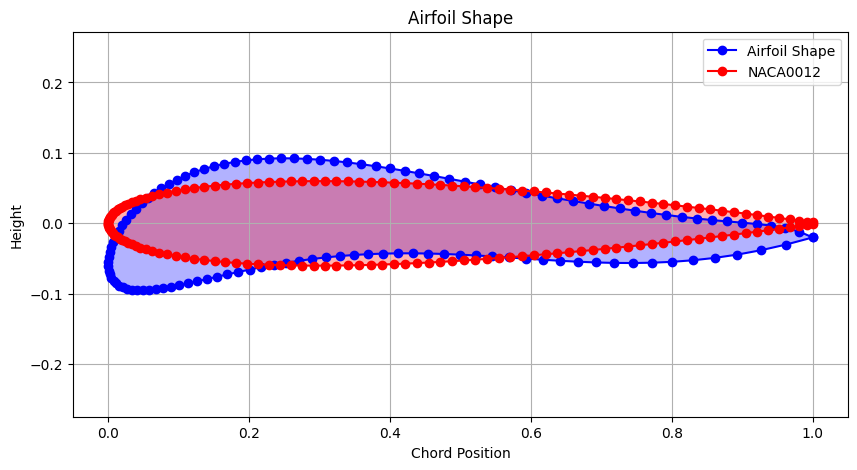

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.2247992753982544, drag : 0.013347205705940723
direction 1.00, lift improvement 13.31%, drag improvement 10.88%


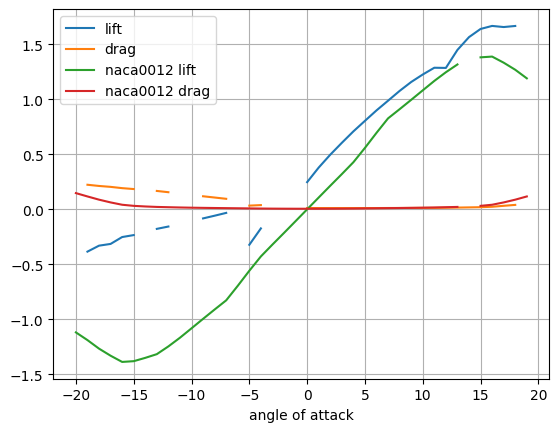

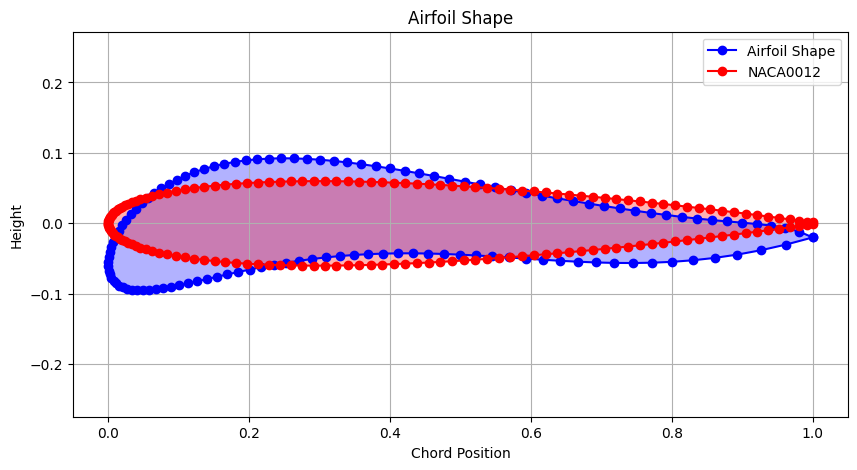

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.2247992753982544, drag : 0.013347205705940723
direction 1.00, lift improvement 13.31%, drag improvement 10.88%


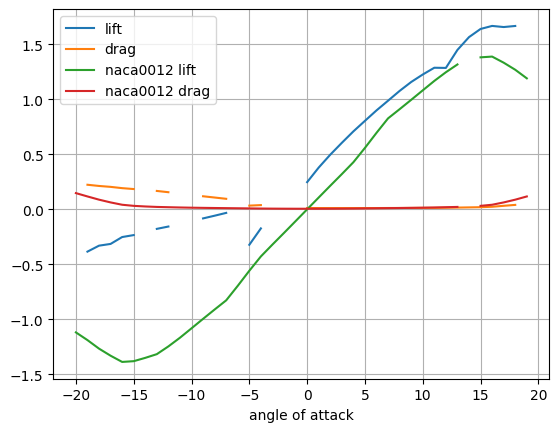

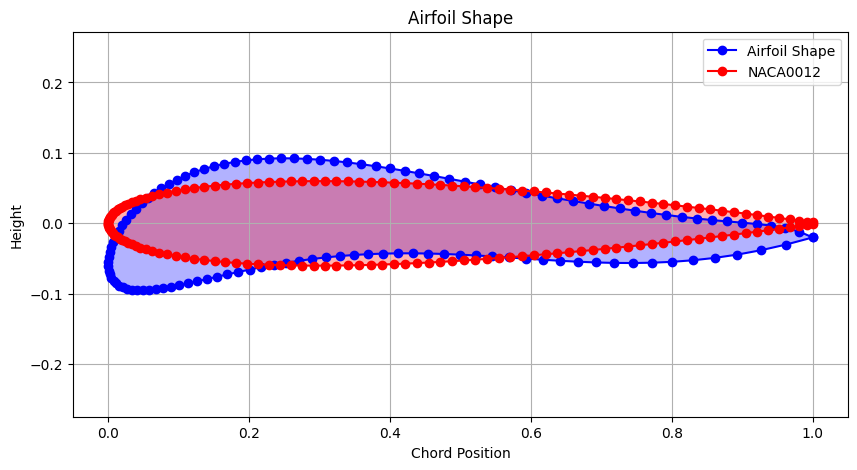

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.2247992753982544, drag : 0.013347205705940723
direction 1.00, lift improvement 13.31%, drag improvement 10.88%


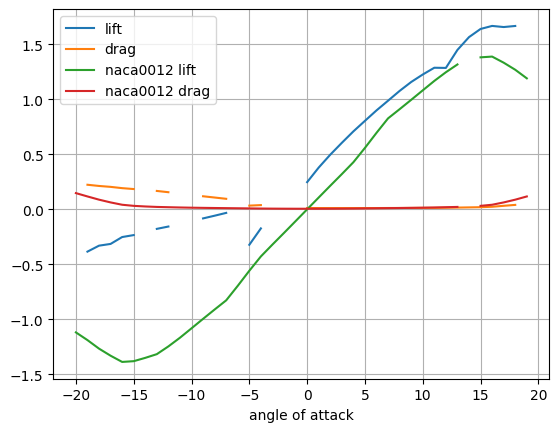

In [29]:
naca_a , naca_cl, naca_cd = naca_eval()
for gen, population in populations.items():
    for ind, fit in population:
        if fit[0] != 0 and fit[1] != -1e5:
            if fit[0] in pareto_l:
                best_indiv = np.array([ind[:n_ctr_pts], np.abs(ind[n_ctr_pts:])])
                best, foil = airfoil(best_indiv,  n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
                direction = fit[0] / abs(fit[0])
                naca0012_fit = np.array(fitness(naca0012))
                lift_improvement = ((np.abs(fit[0]) - naca0012_fit[0]) / naca0012_fit[0]) * 100
                drag_improvement = ((naca0012_fit[1] - np.abs(fit[1])) / naca0012_fit[1]) * 100
                if lift_improvement > 0 and drag_improvement > 0:
                    plot_foil(best)
                    a, cl, cd = evaluate_airfoil_angle_attacks(ind)
                    plt.figure()
                    plt.plot(a, cl, label="lift")
                    plt.plot(a, cd, label="drag")
                    plt.plot(naca_a, naca_cl, label="naca0012 lift")
                    plt.plot(naca_a, naca_cd, label="naca0012 drag")
                    plt.legend()
                    plt.xlabel("angle of attack")
                    plt.grid(True)
                    print(f"naca0012 fitness : lift {naca0012_fit[0]}, drag : {naca0012_fit[1]}")
                    print(f"best indiv fitness : lift {fit[0]}, drag : {-fit[1]}")
                    print(f"direction {direction:.2f}, lift improvement {lift_improvement:.2f}%, drag improvement {drag_improvement:.2f}%")

                


## Section 2

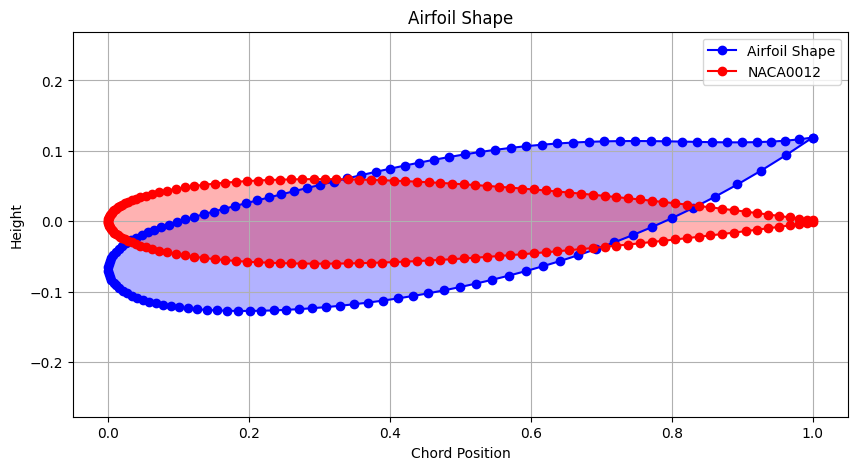

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift -0.260678231716156, drag : 0.006393325515091419
direction -1.00, lift improvement -75.88%, drag improvement 57.31%


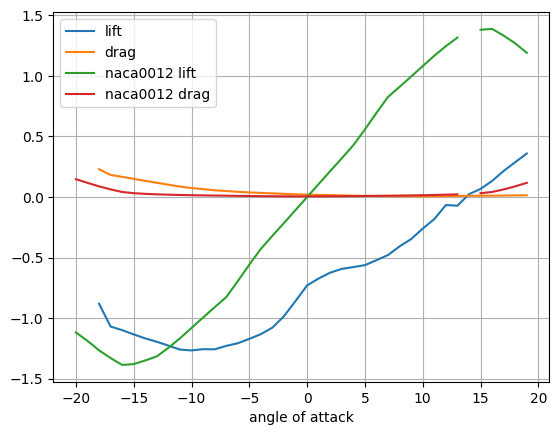

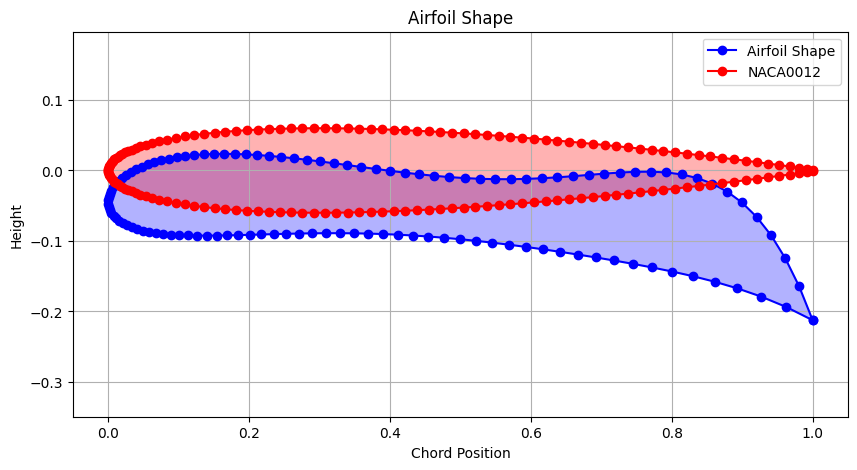

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.6856962442398071, drag : 0.05265720188617706
direction 1.00, lift improvement 55.95%, drag improvement -251.58%


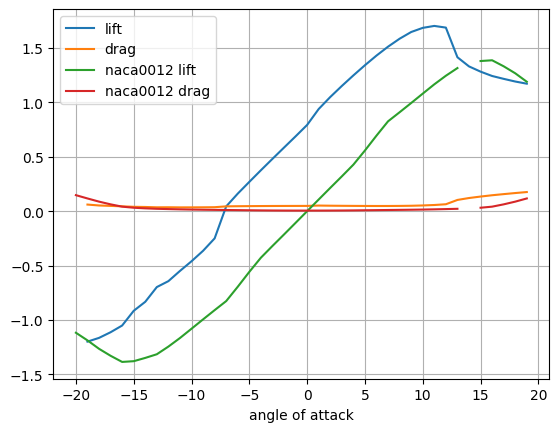

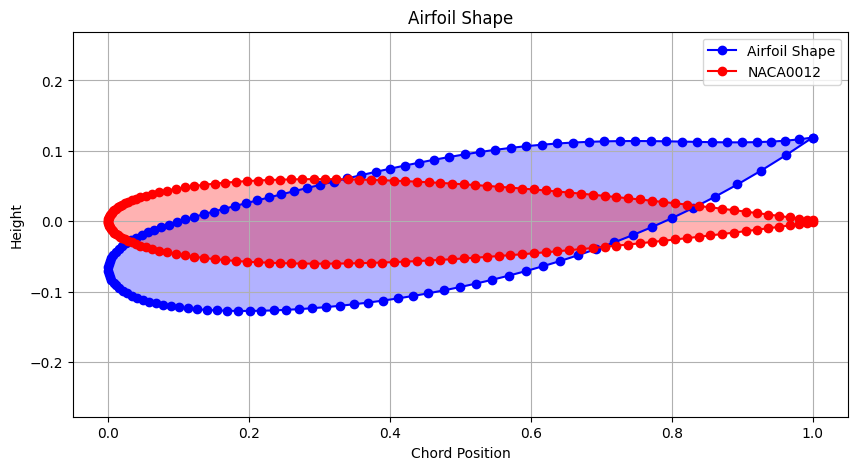

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift -0.260678231716156, drag : 0.006393325515091419
direction -1.00, lift improvement -75.88%, drag improvement 57.31%


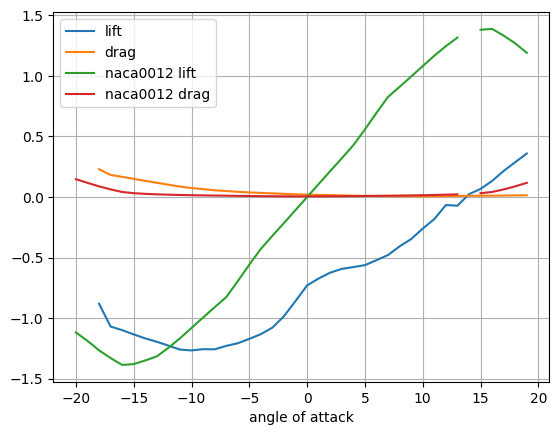

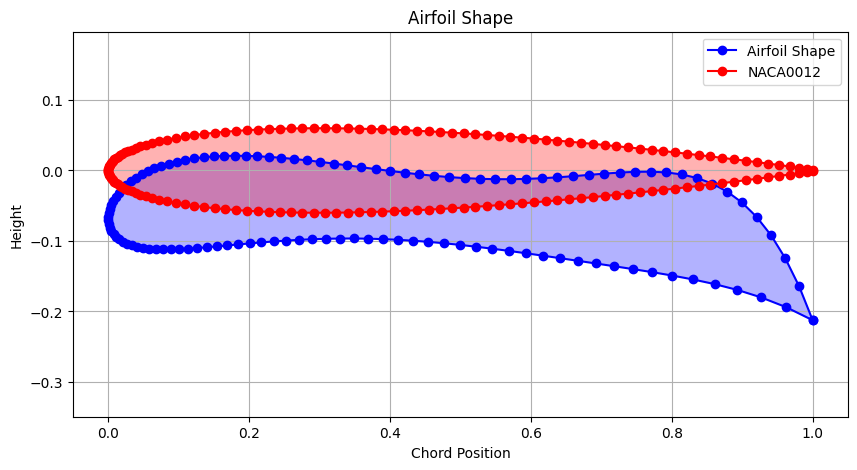

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.6487421989440918, drag : 0.04957649111747742
direction 1.00, lift improvement 52.53%, drag improvement -231.01%


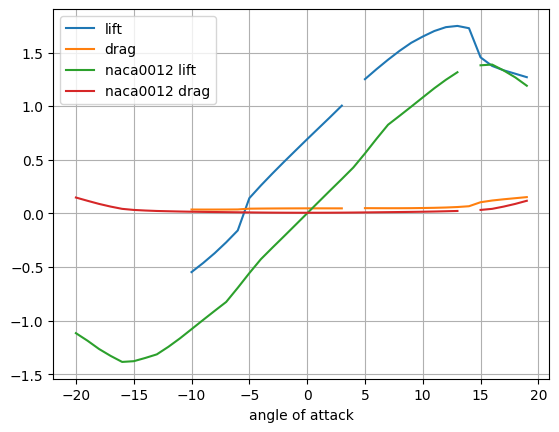

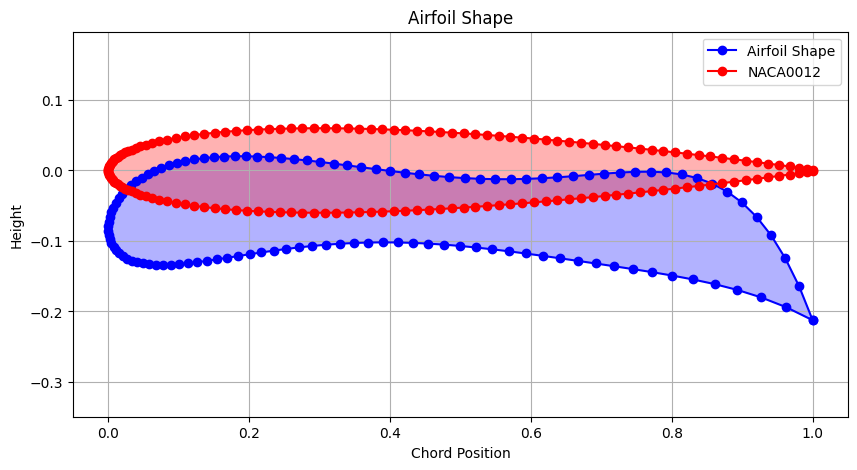

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.6320035457611084, drag : 0.049402300268411636
direction 1.00, lift improvement 50.98%, drag improvement -229.85%


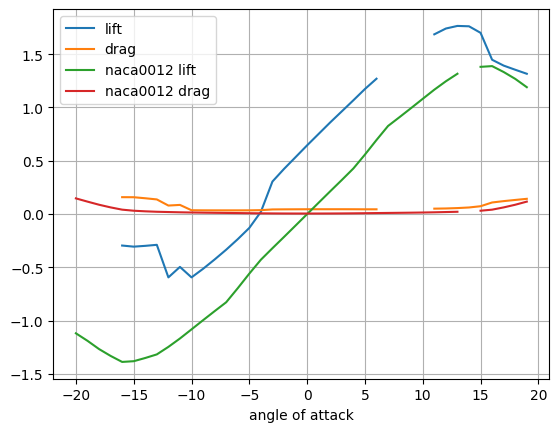

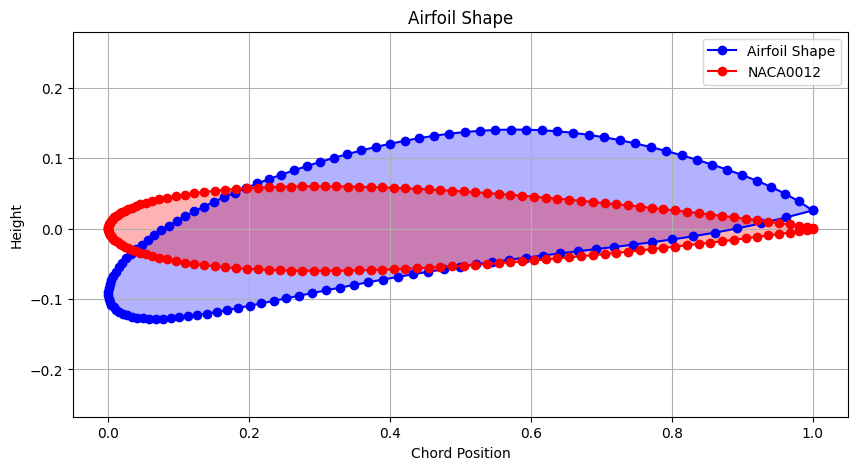

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.8668080568313599, drag : 0.01262066513299942
direction 1.00, lift improvement -19.81%, drag improvement 15.73%


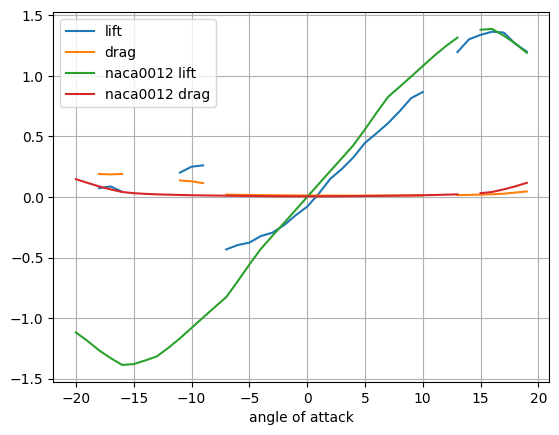

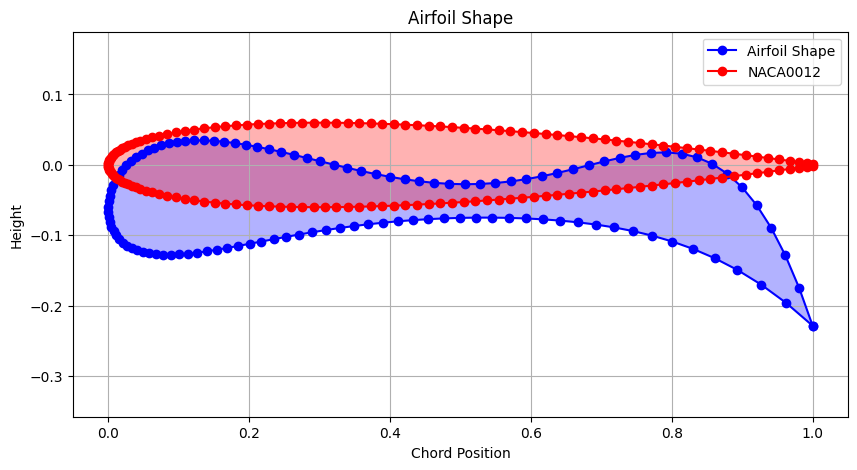

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.895330786705017, drag : 0.056585270911455154
direction 1.00, lift improvement 75.34%, drag improvement -277.81%


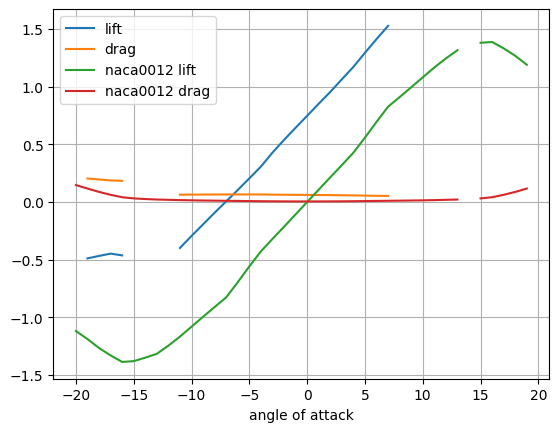

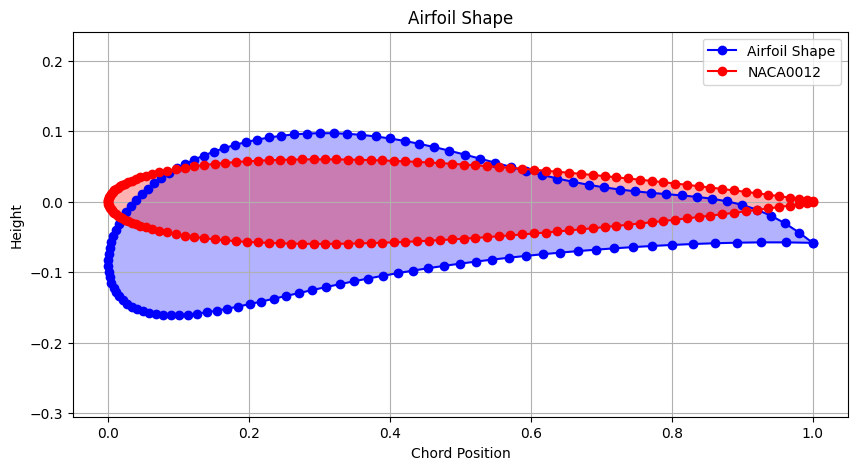

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.236806869506836, drag : 0.013636712916195393
direction 1.00, lift improvement 14.42%, drag improvement 8.95%


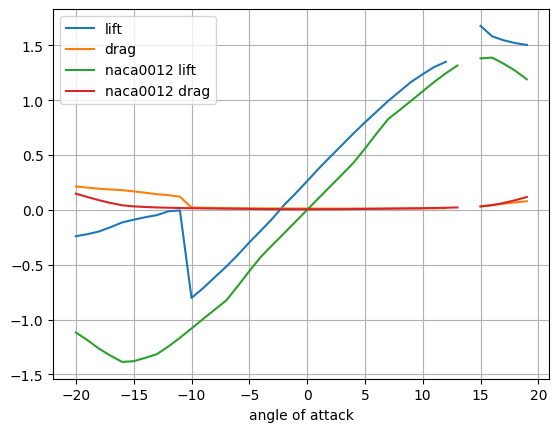

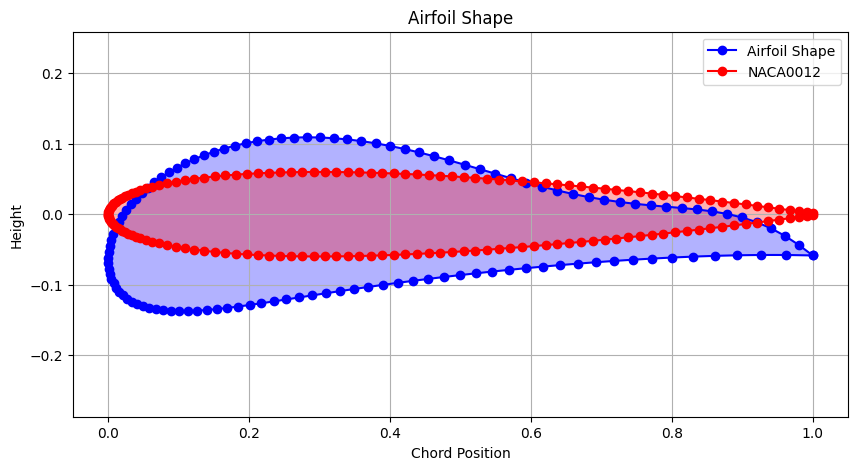

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.5274044275283813, drag : 0.014758596196770668
direction 1.00, lift improvement 41.30%, drag improvement 1.46%


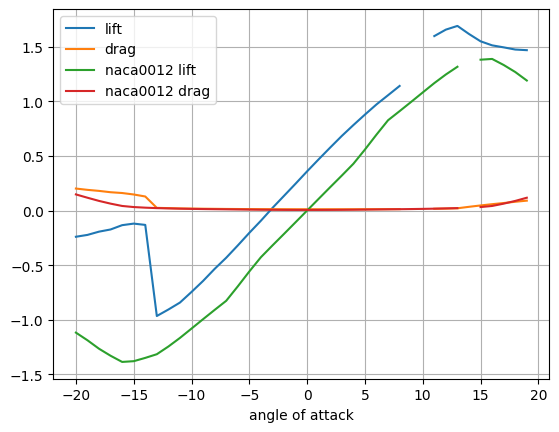

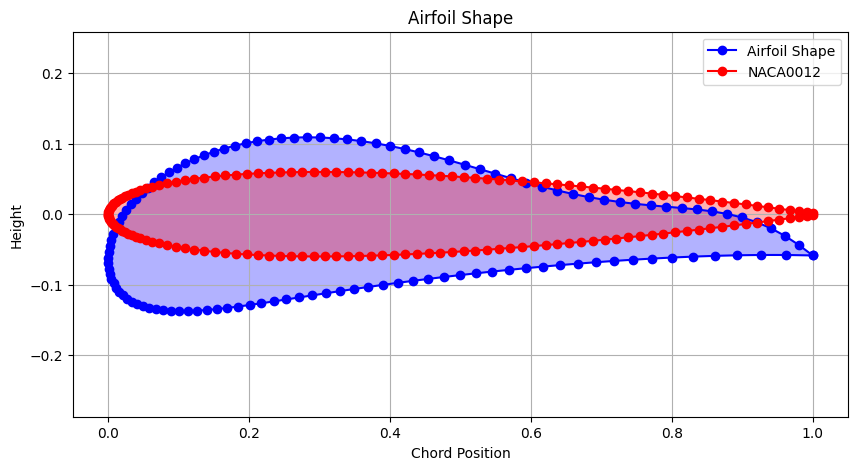

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.5274044275283813, drag : 0.014758596196770668
direction 1.00, lift improvement 41.30%, drag improvement 1.46%


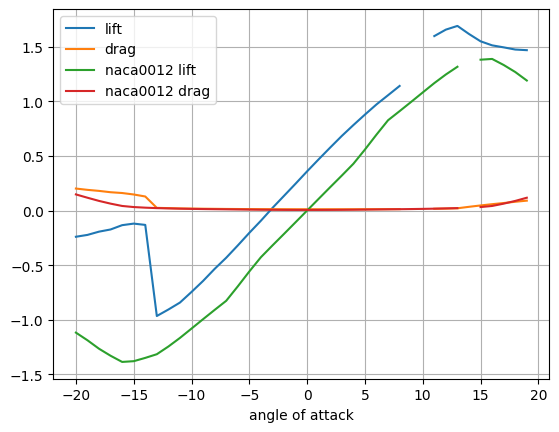

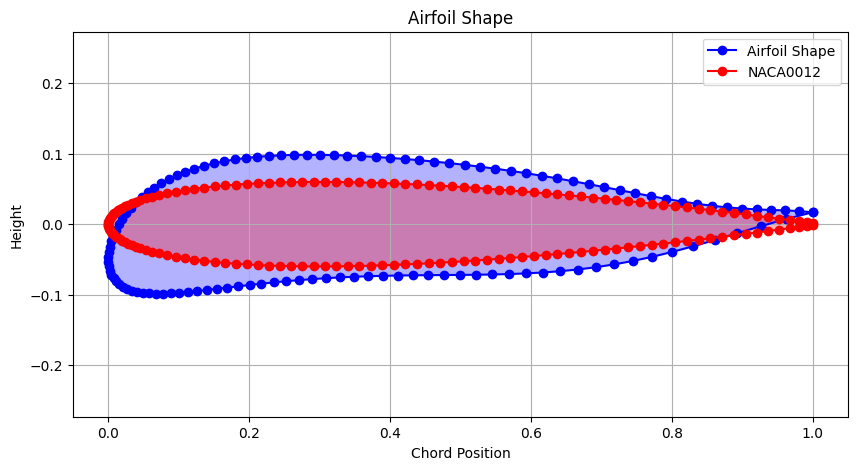

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.6722127795219421, drag : 0.01065556425601244
direction 1.00, lift improvement -37.81%, drag improvement 28.85%


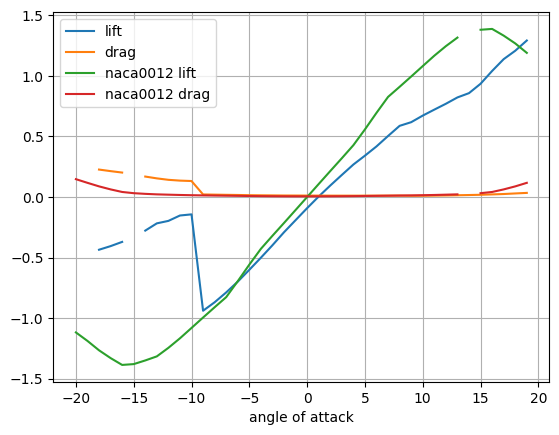

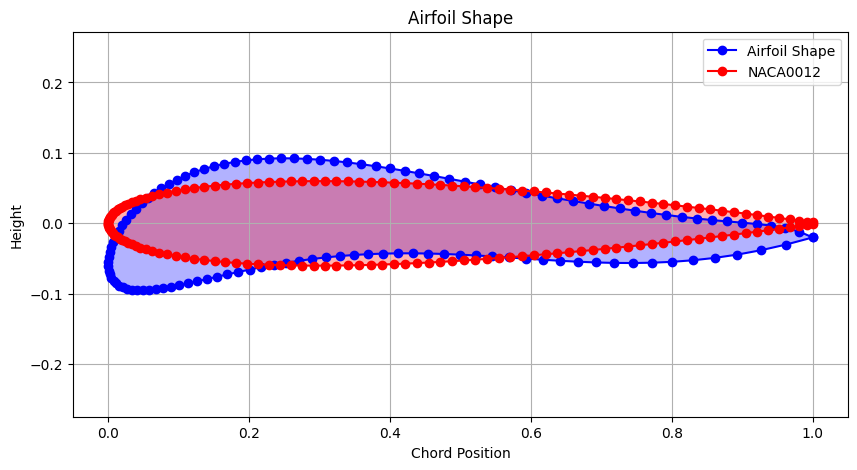

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.2247992753982544, drag : 0.013347205705940723
direction 1.00, lift improvement 13.31%, drag improvement 10.88%


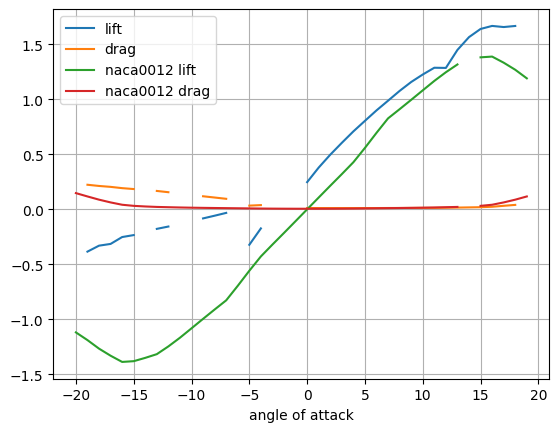

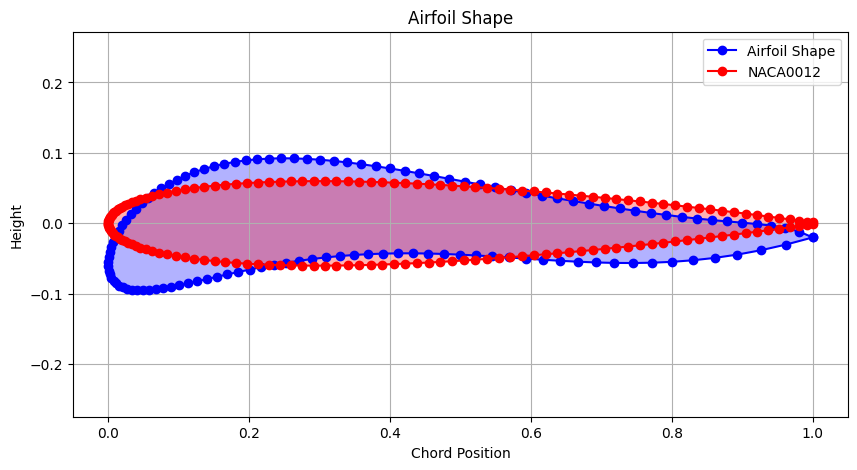

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.2247992753982544, drag : 0.013347205705940723
direction 1.00, lift improvement 13.31%, drag improvement 10.88%


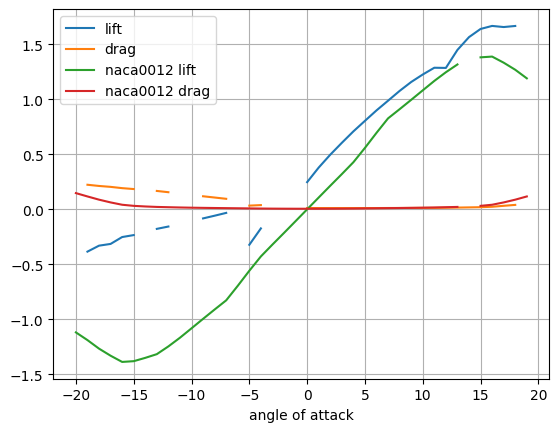

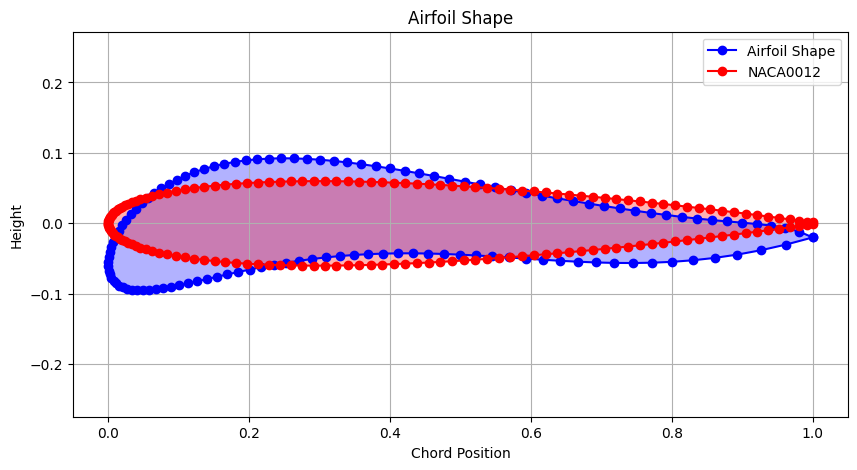

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.2247992753982544, drag : 0.013347205705940723
direction 1.00, lift improvement 13.31%, drag improvement 10.88%


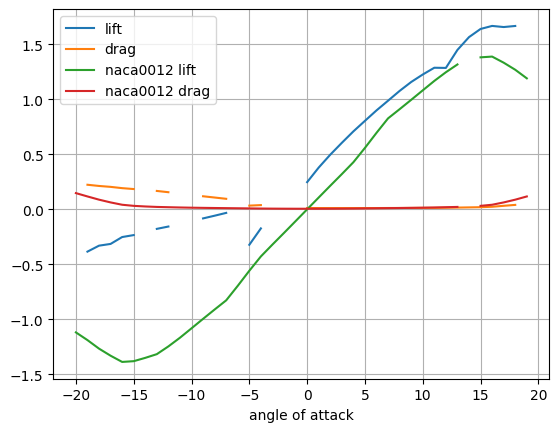

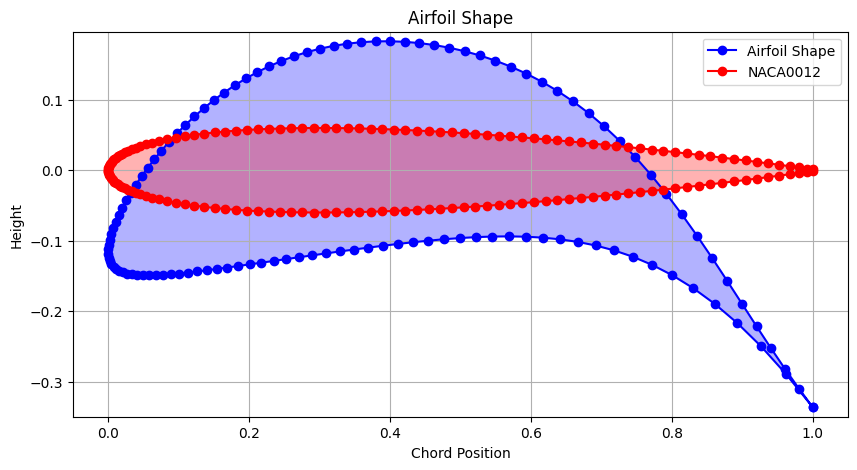

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 2.2694358825683594, drag : 0.21099363267421722
direction 1.00, lift improvement 109.95%, drag improvement -1308.77%


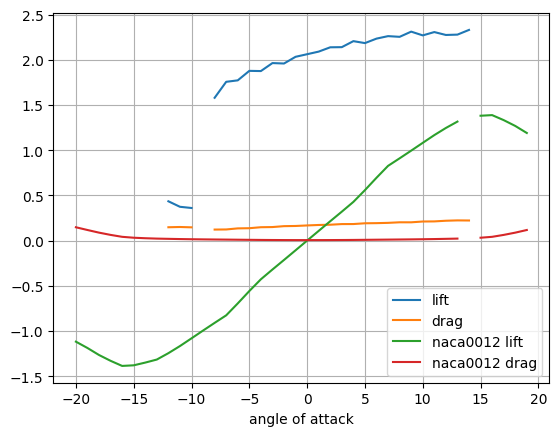

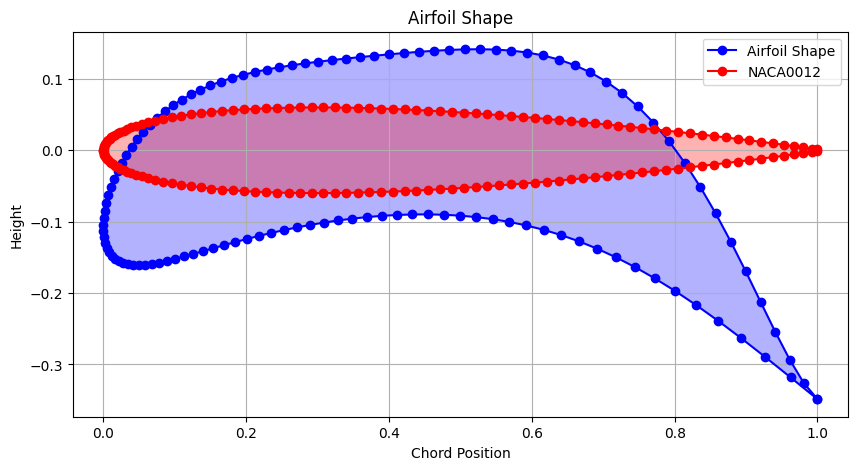

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.9915335178375244, drag : 0.18122102320194244
direction 1.00, lift improvement 84.24%, drag improvement -1109.99%


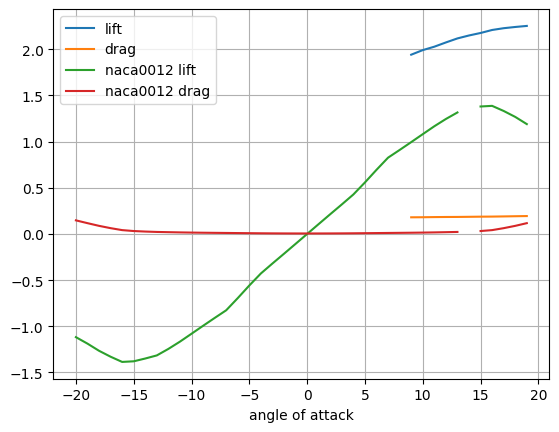

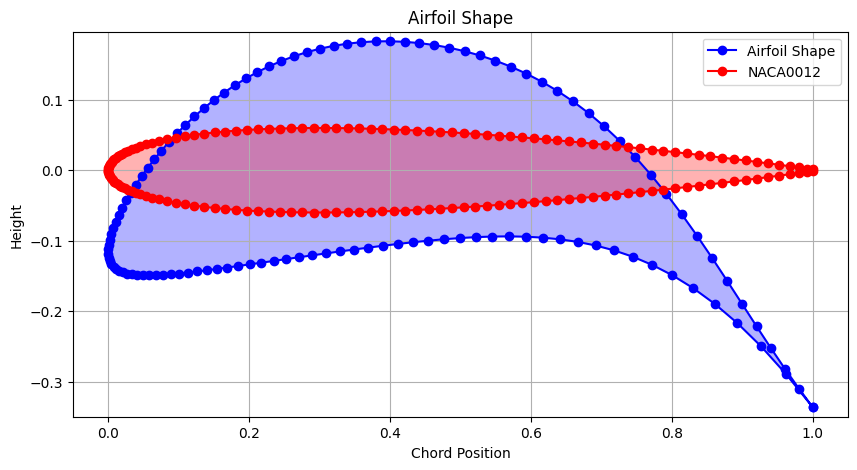

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 2.2694358825683594, drag : 0.21099363267421722
direction 1.00, lift improvement 109.95%, drag improvement -1308.77%


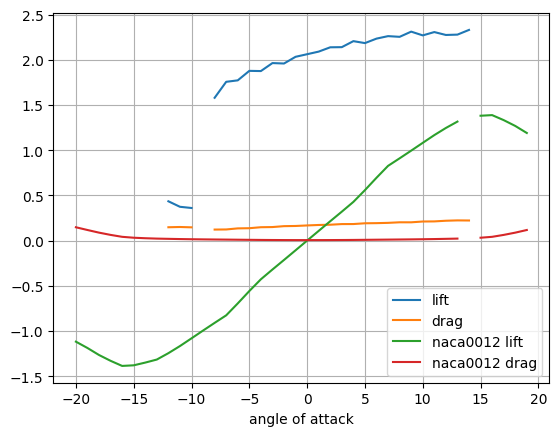

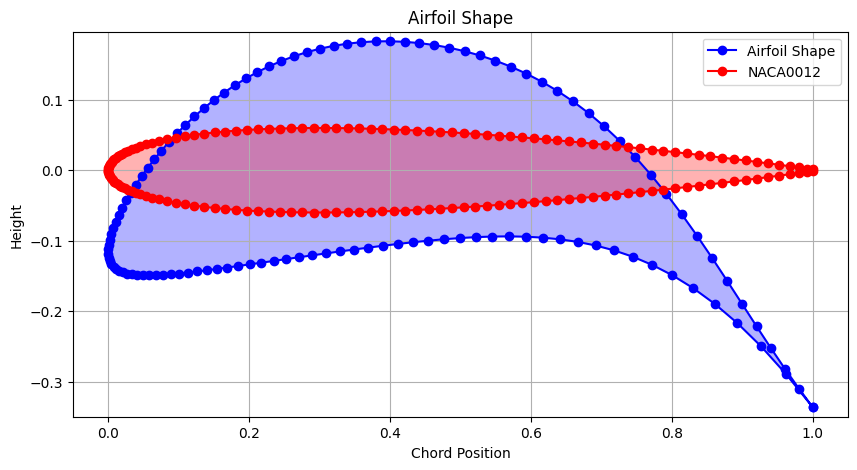

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 2.2694358825683594, drag : 0.21099363267421722
direction 1.00, lift improvement 109.95%, drag improvement -1308.77%


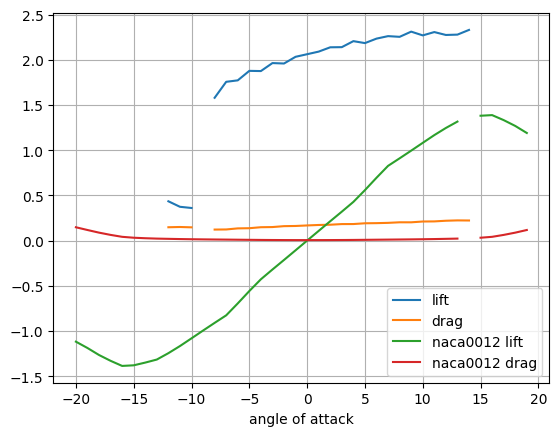

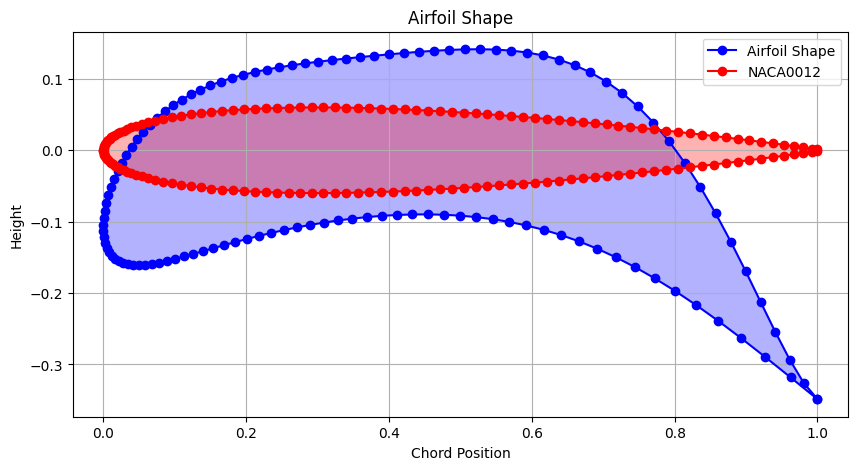

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.9915335178375244, drag : 0.18122102320194244
direction 1.00, lift improvement 84.24%, drag improvement -1109.99%


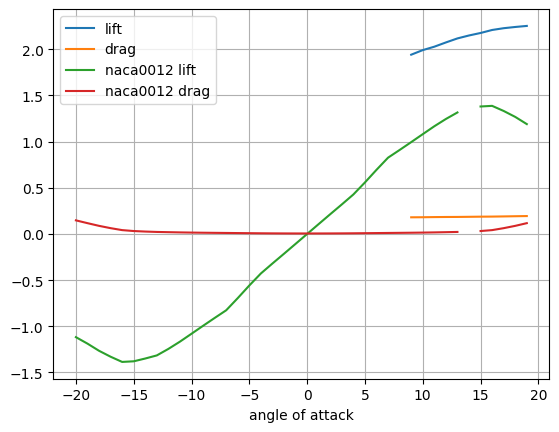

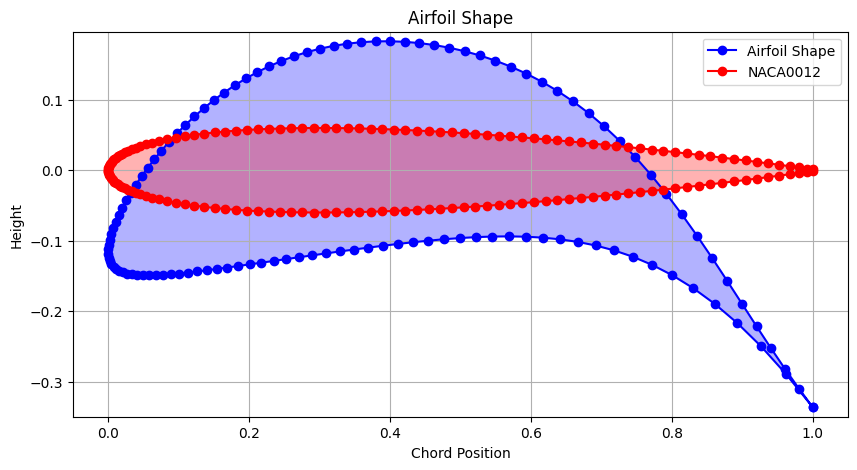

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 2.2694358825683594, drag : 0.21099363267421722
direction 1.00, lift improvement 109.95%, drag improvement -1308.77%


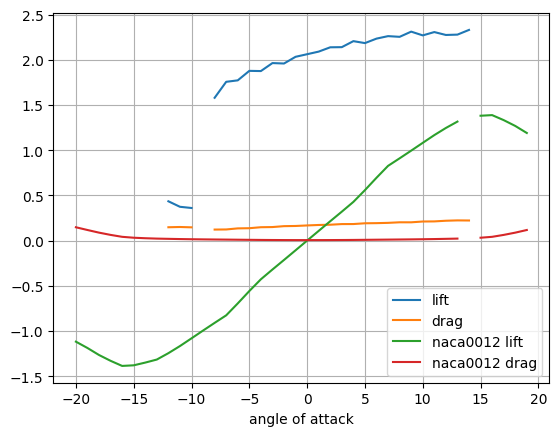

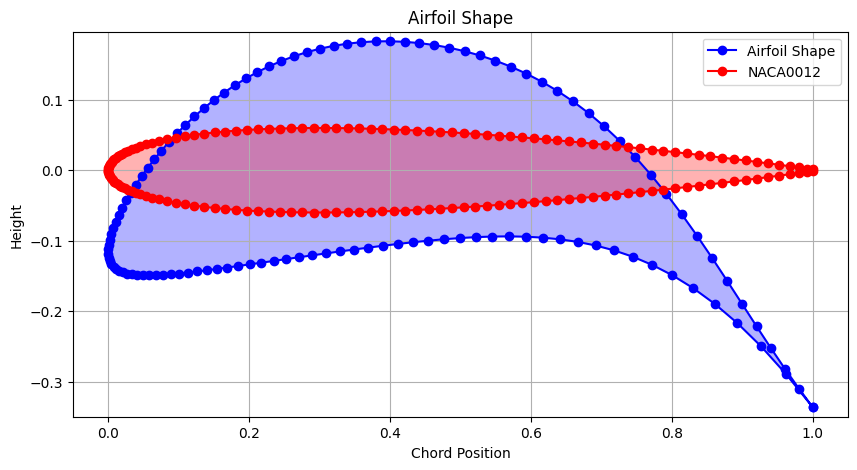

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 2.2694358825683594, drag : 0.21099363267421722
direction 1.00, lift improvement 109.95%, drag improvement -1308.77%


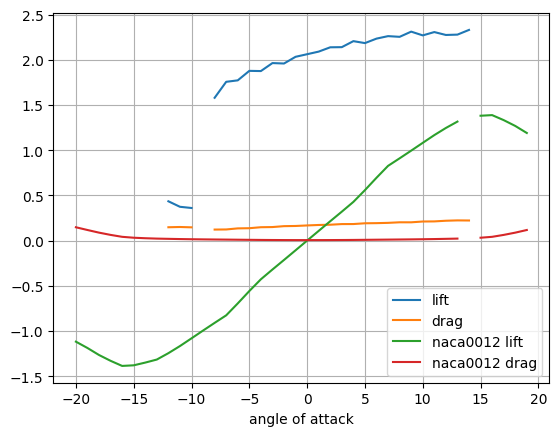

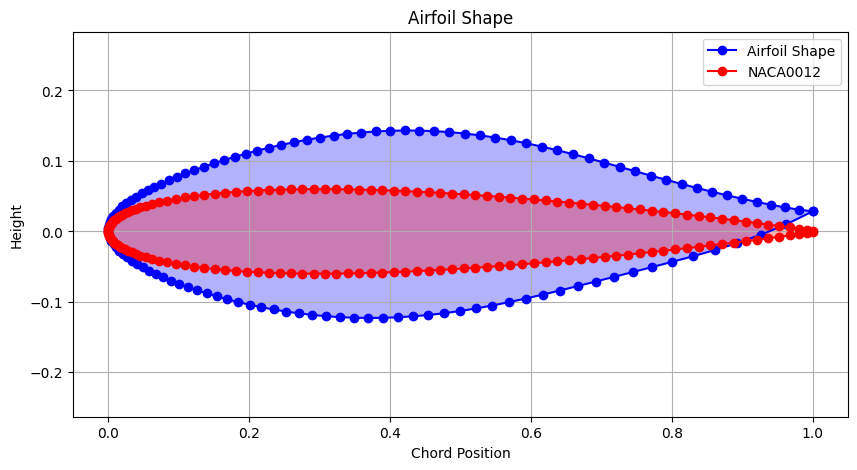

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.7347959876060486, drag : 0.011561300605535507
direction 1.00, lift improvement -32.02%, drag improvement 22.81%


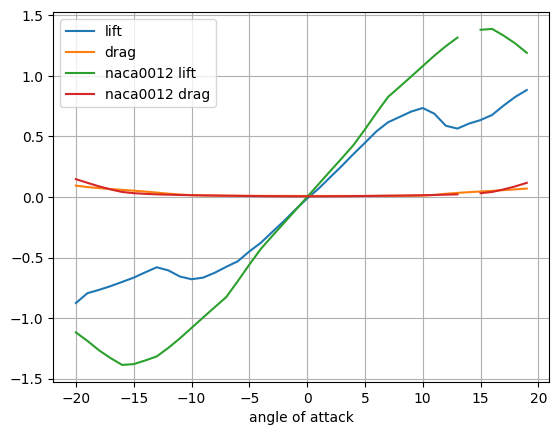

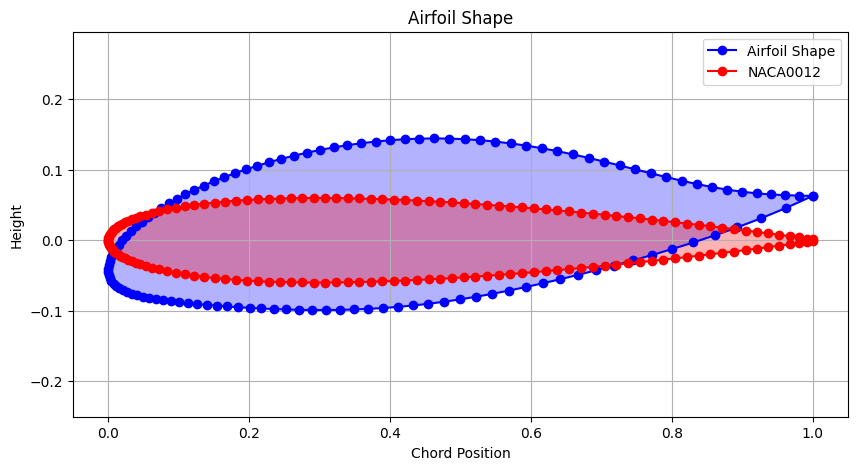

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.599824845790863, drag : 0.007743287831544876
direction 1.00, lift improvement -44.51%, drag improvement 48.30%


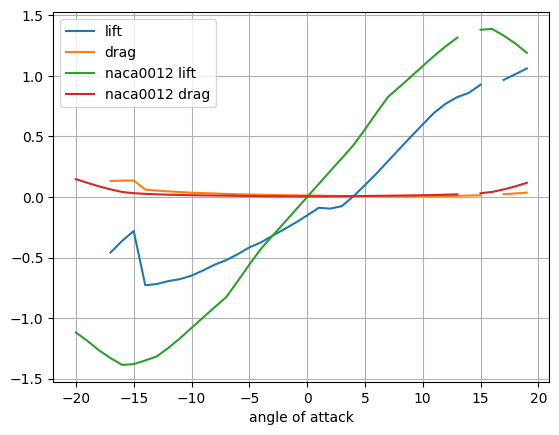

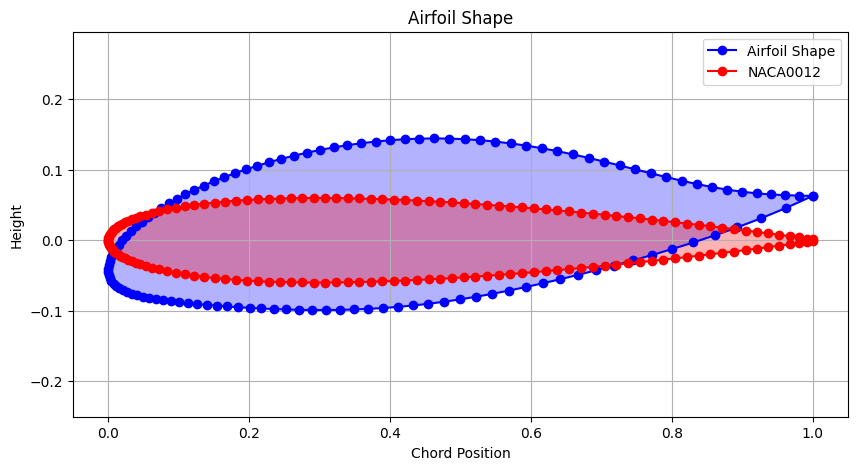

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.599824845790863, drag : 0.007743287831544876
direction 1.00, lift improvement -44.51%, drag improvement 48.30%


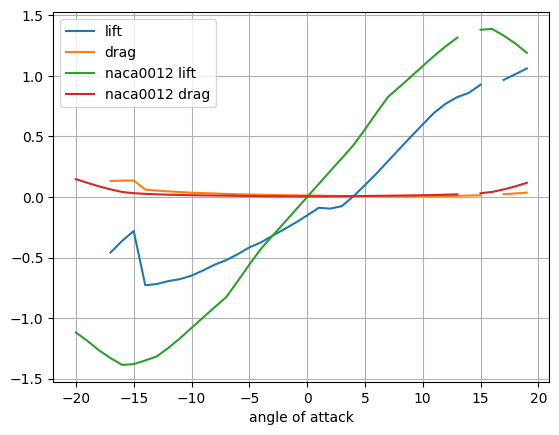

In [30]:
naca_a , naca_cl, naca_cd = naca_eval()
for gen, population in populations.items():
    for ind, fit in population:
        if fit[0] != 0 and fit[1] != -1e5:
            if fit[0] in pareto_l:
                best_indiv = np.array([ind[:n_ctr_pts], np.abs(ind[n_ctr_pts:])])
                best, foil = airfoil(best_indiv,  n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
                direction = fit[0] / abs(fit[0])
                naca0012_fit = np.array(fitness(naca0012))
                lift_improvement = ((np.abs(fit[0]) - naca0012_fit[0]) / naca0012_fit[0]) * 100
                drag_improvement = ((naca0012_fit[1] - np.abs(fit[1])) / naca0012_fit[1]) * 100
                plot_foil(best)
                a, cl, cd = evaluate_airfoil_angle_attacks(ind)
                plt.figure()
                plt.plot(a, cl, label="lift")
                plt.plot(a, cd, label="drag")
                plt.plot(naca_a, naca_cl, label="naca0012 lift")
                plt.plot(naca_a, naca_cd, label="naca0012 drag")
                plt.legend()
                plt.xlabel("angle of attack")
                plt.grid(True)
                print(f"naca0012 fitness : lift {naca0012_fit[0]}, drag : {naca0012_fit[1]}")
                print(f"best indiv fitness : lift {fit[0]}, drag : {-fit[1]}")
                print(f"direction {direction:.2f}, lift improvement {lift_improvement:.2f}%, drag improvement {drag_improvement:.2f}%")

                
